In [36]:
from sklearn.cluster import KMeans
from cartopy.crs import PlateCarree
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## Clustering the headlines

In this notebook, the latitudes and longitudes obtained from the previous step will be clustered using the K-Means algorithm to determine where an outbreak is occuring

### Viewing the Data

In [61]:
with open("outbreaks_lat_longs.csv", encoding="utf8", errors="ignore") as f:
    data = pd.read_csv(f, index_col=0)

Converting the columns to a float64 type.

In [62]:
data["Latitude"].astype("float64")
data["Longitude"].astype("float64")

0      -80.13005
1      -34.88111
2      -95.36327
3      -84.38798
4      -46.63611
         ...    
645    -74.00597
646    -12.18076
647      9.83723
648   -120.64128
649    -98.48141
Name: Longitude, Length: 649, dtype: float64

In [63]:
data.head()

,Headline,City,Country,Latitude,Longitude
0,First Case of Zika in Miami Beach,Miami Beach,United States,25.79065,-80.13005
1,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil,-8.05389,-34.88111
2,Zika Concerns are Spreading in Houston,Houston,United States,29.76328,-95.36327
3,The CDC in Atlanta is Growing Worried,Atlanta,United States,33.74900,-84.38798
4,Zika Infested Monkeys in Sao Paulo,Sao Paulo,Brazil,-23.54750,-46.63611


In [64]:
lats = data["Latitude"]
longs = data["Longitude"]

### Visualising the headlines on the world map


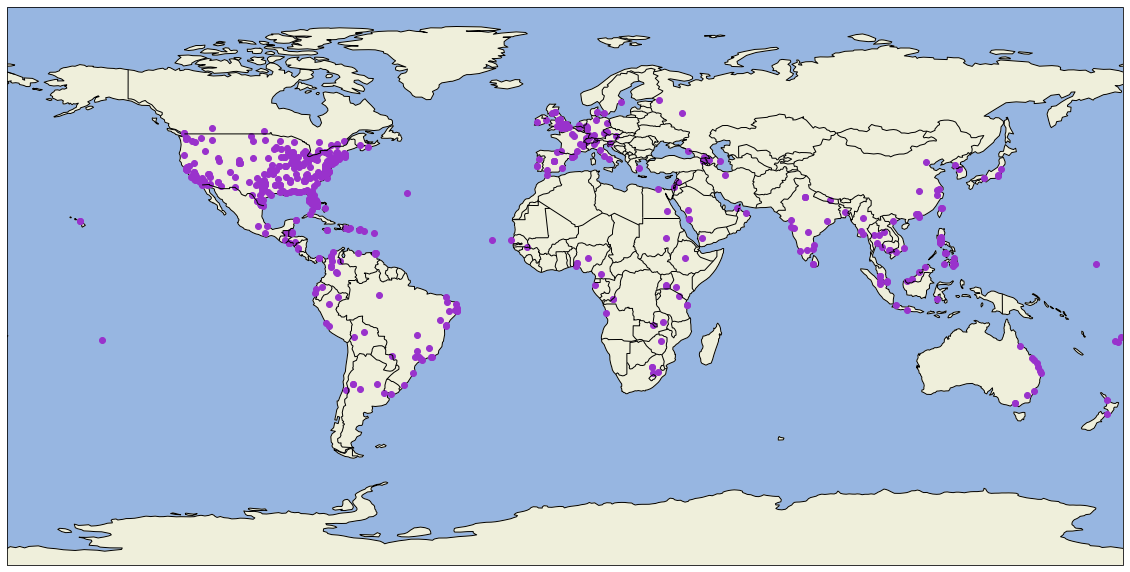

In [65]:
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.scatter(longs, lats, color="darkorchid")
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
plt.show()

Plotting the latitudes and longitudes on the map shows that there are dense clusters in Europe and North America, this implies that there may be disease outbreaks in these regions. There also appear to be a few headlines from South East Asia

### Clustering using K-Means

Initially we'll produce a naive K-Means with 7 clusters, there are 7 continents (even though Antartica Doesn't Show any headlines) so there will be 7 clusters.

When plotting these naive clusters, it is expected that there will be one cluster centering on each continent.

In [128]:
kmeans = KMeans(n_clusters=7)

In [129]:
X = data[["Latitude", "Longitude"]]

In [130]:
labels = kmeans.fit_predict(X)

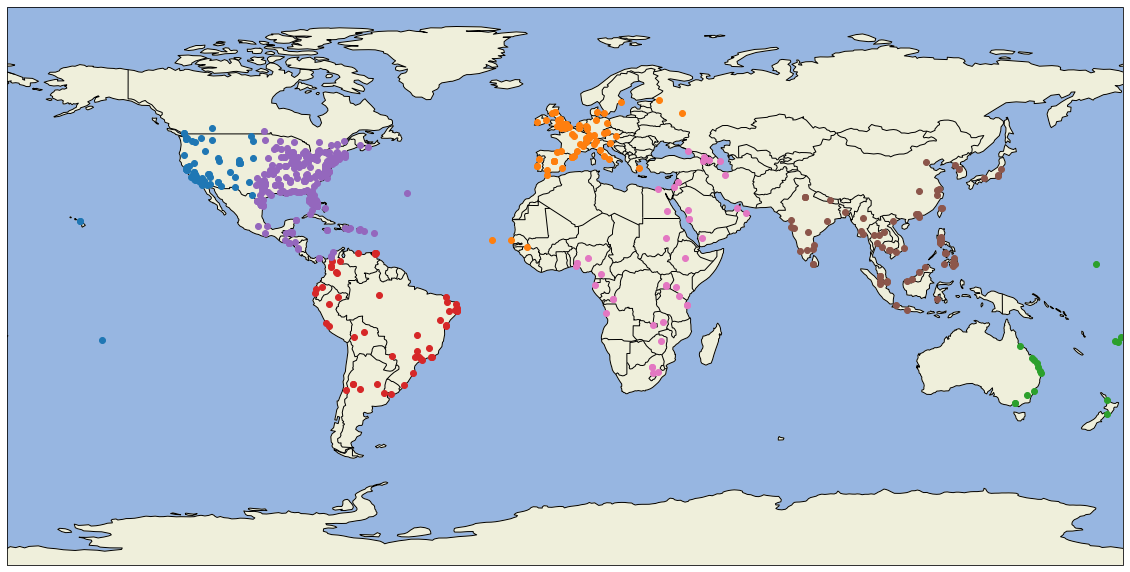

In [131]:
fig = plt.figure(figsize=(20, 12))
centroids = kmeans.cluster_centers_
ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)

unique_labels = np.unique(labels)

for i in unique_labels:
    ax.scatter(data[labels == i]["Longitude"], data[labels == i]["Latitude"])
ax.set_global()
plt.show()

This plot shows that two of the clusters are in North America, and split by the West and the East. It was initially assumed that with there being 7 clusters, and there being no headline from Antartica, that one continent will have more than one cluster, this assumption holds true with North America having two clusters.

This clustering is far from efficient, as there can be many more clusters. The elbow method will be employed to find the optimum number of clusters.

### Using the elbow method to get the optimum value for k

The following code will determind the optimum number of k for the K-Means algorithm. The code will be run for k values between 5 and 15, the inertia values of the k means for the value of k will be used to make an elbow plot, from which the value for k will be determined.

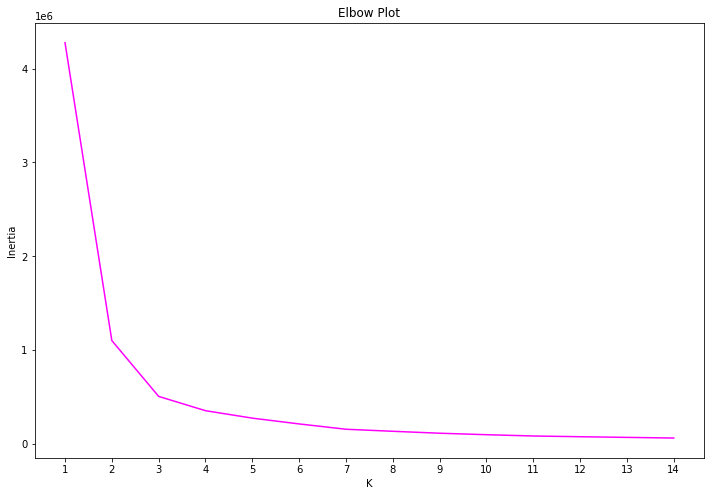

In [133]:
fig = plt.figure(figsize=(12, 8))

k_values = range(1, 15)
inertia_values = [KMeans(k).fit(X).inertia_
                  for k in k_values]
 
plt.plot(k_values, inertia_values, color="magenta")
plt.xticks(k_values)
plt.title("Elbow Plot")
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

This elbow plot shows that the optimum number for k based on inertia values should be 3, this is indeed a very surprising find.

### Using k=3 for clustering

Based on the findings of the elbow plot, clustering will now be done using k = 3.

In [238]:
kmeans = KMeans(n_clusters=3)

In [135]:
X = data[["Latitude", "Longitude"]]

In [136]:
labels = kmeans.fit_predict(X)

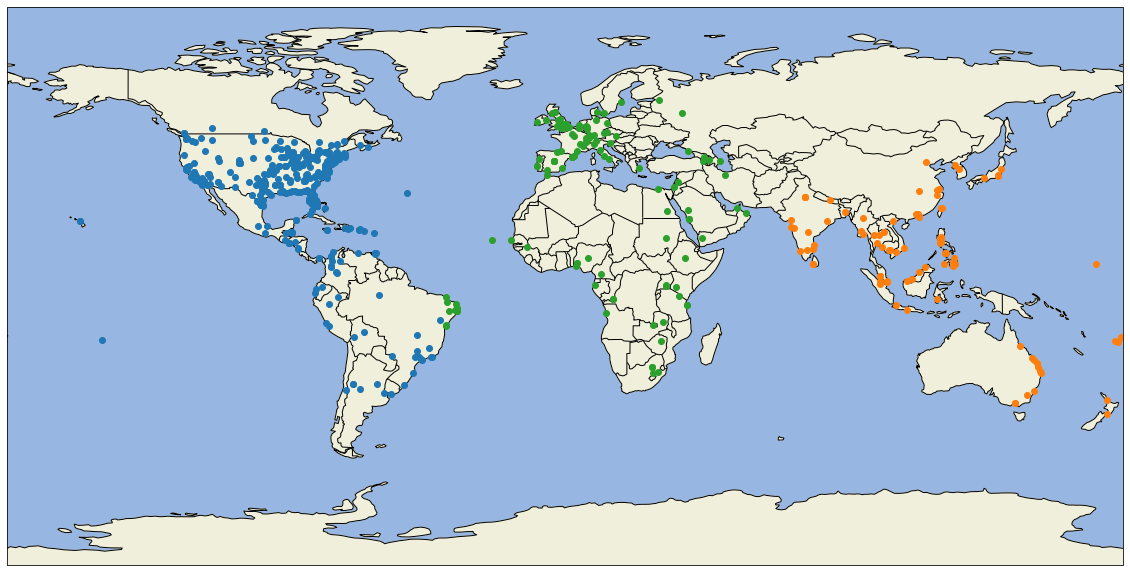

In [137]:
fig = plt.figure(figsize=(20, 12))
centroids = kmeans.cluster_centers_
ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)

unique_labels = np.unique(labels)

for i in unique_labels:
    ax.scatter(data[labels == i]["Longitude"], data[labels == i]["Latitude"])
ax.set_global()
plt.show()

Clustering based on the value obtained using the elbow method produces three distinct clusters, one for North and South America, one for Europe and Africa, and one for Asia and Australia

### Gausian Mixture Model

The spreading of a disease could be considered to form a gaussian distribution, based on this asumption a gausian mixture model can be used to discover clusters. The number of clusters will be assigned as to minimize the number of outliers.

In [169]:
from sklearn.mixture import GaussianMixture

In [212]:
gmm = GaussianMixture(n_components=11)

In [213]:
labels = gmm.fit_predict(X)

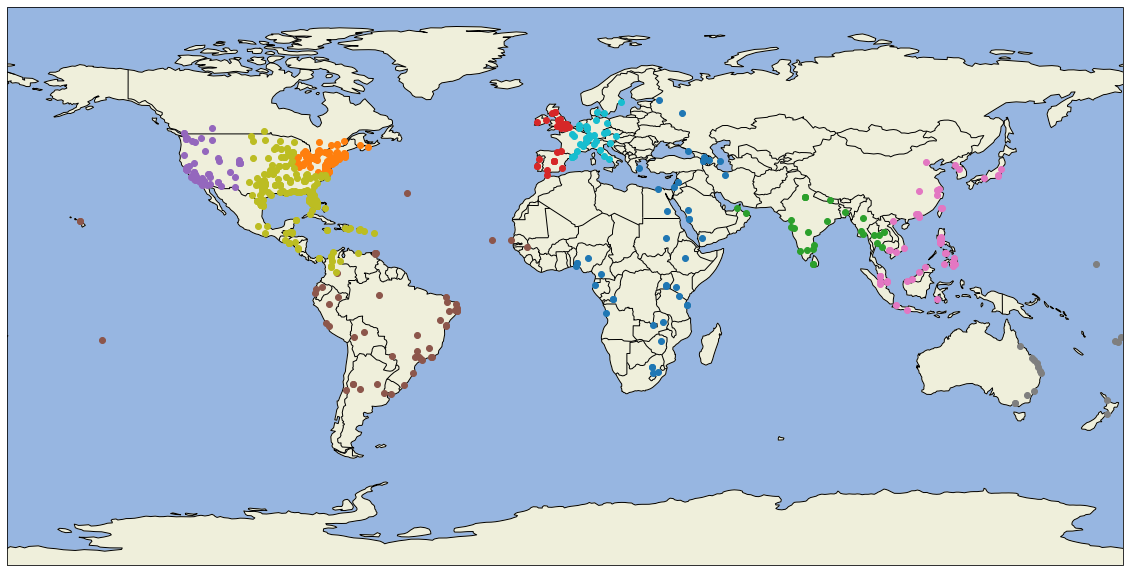

In [214]:
fig = plt.figure(figsize=(20, 12))
centroids = kmeans.cluster_centers_
ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)

unique_labels = np.unique(labels)

for i in unique_labels:
    ax.scatter(data[labels == i]["Longitude"], data[labels == i]["Latitude"])
ax.set_global()
plt.show()

This clusters formed from the gaussian mixture model show some differences compared to the K-Means algorithm.

3 clusters is far too less to acurately determine outbreaks, thus for this reason 11 clusters will be used for the GMM to determine clusters.

So far, for clustering, the euclidean distance between points was used to determine the cluster, however on the map the distance between 2 points is given by the great circle distance. Now the great circle distance will be used with DBscan to produce accurate

### Using DBScan with Great Circle Distance

As mentioned above, the euclidean distance is not appropriate to use when talking about the distance between two points on the earth, therefore the clusters derived from K-Means clustering are not appropriate enough to determine disease outbreaks. To fix this issue, Density Based Spatial clustering will be utilized to produce appropriate clustering. The great circle distance function will be used as a metric for this algorithm.

The function below returns the GCD(great circle distance) between two points on the earth in miles, the most important hyperparameter to set in a DBscan algorithm is the maximum distance between a point for it to be considered part of a dense cluster. Since the distance will be in miles, 500 miles is an appropriate distance to determine whether a headline is part of a cluster.

In [325]:
def great_circle_distance(x, y):
    x, y = np.radians(x), np.radians(y)
    delta_x, delta_y = y[0] - x[0], y[1] - x[1]
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(x[0]), cos(y[0]),
                                                   sin(delta_y / 2) ** 2])
    return 3956 * (2 * asin(haversin ** 0.5))

In [283]:
north = [90.0, 0]
south = [-90.0, 0]

print(great_circle_distance(north, south))

12428.14053760122


In [332]:
dbscan = DBSCAN(eps=550, metric=great_circle_distance)

In [333]:
labels = dbscan.fit_predict(X)

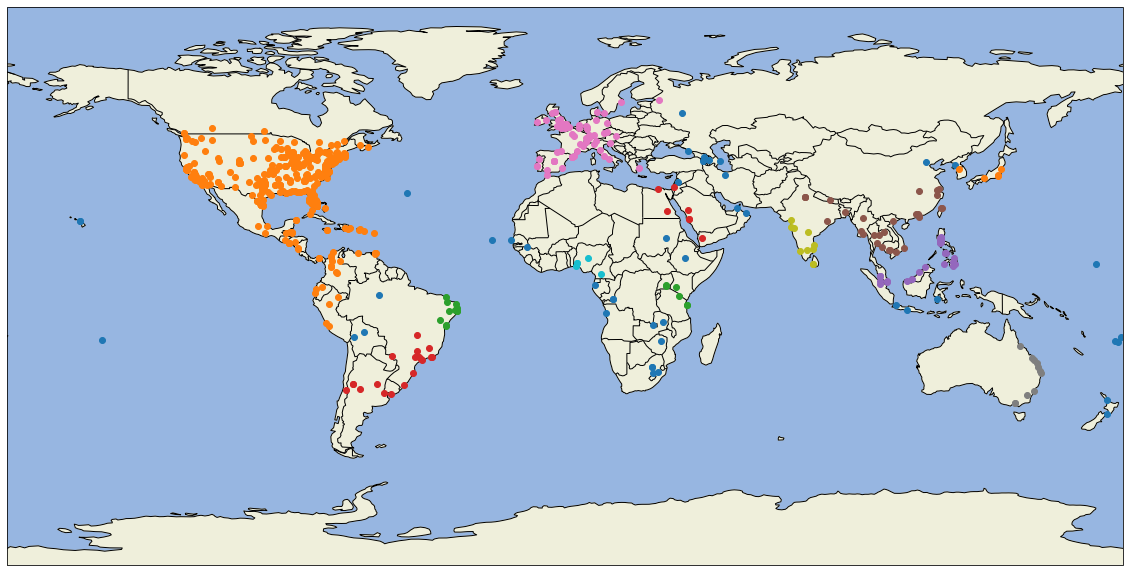

In [334]:
fig = plt.figure(figsize=(20, 12))

ax = plt.axes(projection=PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS)

unique_labels = np.unique(labels)

for i in unique_labels:
    ax.scatter(data[labels == i]["Longitude"], data[labels == i]["Latitude"])
ax.set_global()

This is the clustering the DBSCAN algorithm produces. It has produced 14 distinc clusters.

## Result

Out of the 3 different clustering algorithms used, I believe the Gausian Mixture Model produces the best clustering as it is based on gaussian distributions, and the spread of diseases could follow this distribution.